In [2]:
"""
error log
ValueError: Error when checking target: expected conv2d_22 to have shape (61, 61, 3) but got array with shape (64, 64, 3)
output of layer is the first and the target is 64*64*3, need to match output
"""

'\nerror log\nValueError: Error when checking target: expected conv2d_22 to have shape (61, 61, 3) but got array with shape (64, 64, 3)\noutput of layer is the first and the target is 64*64*3, need to match output\n'

In [3]:
import os
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from os import listdir

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16199347886273102629
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11581841622765019721
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [5]:
import sys
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/FA2018/tutorials/ferienakademie2018-accelerating-physics-with-deep-learning/')
from functions import *

In [6]:
#forces CPU usage
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [7]:
os.getcwd()

'C:\\Users\\pkicsiny\\Desktop\\FA2018\\tutorials\\ferienakademie2018-accelerating-physics-with-deep-learning'

In [8]:
dataDir = os.getcwd() + '/data/trainSmallFA'
files = listdir(dataDir)
files[0:5]

['sm_goe503_1050_57.npz',
 'sm_goe503_1079_209.npz',
 'sm_goe503_1093_355.npz',
 'sm_goe503_1110_304.npz',
 'sm_goe503_1152_78.npz']

In [9]:
totalLength = len(files)

In [10]:
#array of inputs and outputs (predictions of the network)
inputs = np.empty((totalLength,3,64,64))
targets = np.empty_like(inputs)

In [11]:
np.shape(inputs) == np.shape(targets)

True

### Data prerpocessing

In [12]:
c = 1
for i, file in enumerate(files):
    npfile = np.load(dataDir +'/' + file)
    #a file contains 6 images: 3 for input p, vx, vy and output (ground truth) 
    d = npfile['a']
    inputs[i]  = d[0:3]   # inx, iny, mask 
    targets[i] = d[3:6]   # p, velx, vely
    if c:
        print('Shape of input-target array:',np.shape(targets))
        print('Shape of an element of input + output:',np.shape(d))
        # splits input file content of 6 channels to 3-3
        c = 0

Shape of input-target array: (751, 3, 64, 64)
Shape of an element of input + output: (6, 64, 64)


In [13]:
print('Input maxes:',inputs[:,0,:,:].max(), inputs[:,1,:,:].max(), inputs[:,2,:,:].max())
print('Input mins:',inputs[:,0,:,:].min(), inputs[:,1,:,:].min(), inputs[:,2,:,:].min())
print('Target maxes:',targets[:,0,:,:].max(), targets[:,1,:,:].max(), targets[:,2,:,:].max())
print('Target mins:',targets[:,0,:,:].min(), targets[:,1,:,:].min(), targets[:,2,:,:].min())

Input maxes: 98.70918772289284 36.22861719358889 1.0
Input mins: 0.0 0.0 0.0
Target maxes: 4321.8 171.772 140.251
Target mins: -13757.3 -71.886 -58.4272


In [14]:
normalized_inputs, normalized_targets = normalize_data(inputs,targets,norm = 1)

In [15]:
print('Normalized input maxes:',normalized_inputs[:,0,:,:].max(), normalized_inputs[:,1,:,:].max(), normalized_inputs[:,2,:,:].max())
print('Normalized input mins:',normalized_inputs[:,0,:,:].min(), normalized_inputs[:,1,:,:].min(), normalized_inputs[:,2,:,:].min())
print('Normalized target maxes:',normalized_targets[:,0,:,:].max(), normalized_targets[:,1,:,:].max(), normalized_targets[:,2,:,:].max())
print('Normalized target mins:',normalized_targets[:,0,:,:].min(), normalized_targets[:,1,:,:].min(), normalized_targets[:,2,:,:].min())

Normalized input maxes: 98.70918772289284 36.22861719358889 1.0
Normalized input mins: 0.0 0.0 0.0
Normalized target maxes: 0.5181714179504846 1.739651600742902 1.7284380207634795
Normalized target mins: -1.957152811908768 -0.729521000704373 -0.7706419276952202


### Split datasets

In [16]:
train_val_inputs,train_val_targets,test_inputs,test_targets = randsplit(normalized_inputs,normalized_targets,frac=.9)

In [17]:
#training data
train_val_inputs  = train_val_inputs.transpose(0,2,3,1)
train_val_targets = train_val_targets.transpose(0,2,3,1)

#test dataset
test_inputs  = test_inputs.transpose(0,2,3,1)
test_targets = test_targets.transpose(0,2,3,1)

print('Training data shape:',np.shape(train_val_inputs),np.shape(train_val_targets))
print('Test data shape:',np.shape(test_inputs),np.shape(test_targets))

Training data shape: (675, 64, 64, 3) (675, 64, 64, 3)
Test data shape: (76, 64, 64, 3) (76, 64, 64, 3)


In [17]:
#flattening if last layer is fcl
#train_val_targets = np.reshape(train_val_targets,(len(train_val_targets),-1))
#test_targets = np.reshape(test_targets,(len(test_targets),-1))

In [18]:
print('Training data shape:',np.shape(train_val_inputs),np.shape(train_val_targets))
print('Test data shape:',np.shape(test_inputs),np.shape(test_targets))

Training data shape: (675, 64, 64, 3) (675, 64, 64, 3)
Test data shape: (76, 64, 64, 3) (76, 64, 64, 3)


### Network architecture

In [137]:
#convolution filters
f1 = 8
f2 = 3
#kernel size
k1 = 4
k2 = 2
#stride
s1 = 4
s2 = 2
#padding
p1 = 0
p2 = 0

Toy network

In [138]:
model=keras.Sequential()

conv1 = keras.layers.Conv2D(input_shape = (64,64,3),
                              filters = f1,
                              kernel_size=(k1,k1),
                              strides=(s1, s1),
                              padding='valid',
                              data_format = "channels_last",
                             activation = 'tanh')
conv2 = keras.layers.Conv2D(input_shape = (16,16,3),
                              filters = f2,
                              kernel_size=(k2,k2),
                              strides=(s2, s2),
                              padding='same',
                              data_format = "channels_last",
                              activation = 'tanh')
conv3 = keras.layers.Conv2D(input_shape = (8,8,3),
                              filters = 3,
                              kernel_size=(8,8),
                              strides=(1, 1),
                              padding='same',
                              data_format = "channels_last",
                              activation = 'tanh')
upsample1 = keras.layers.UpSampling2D(size=(4, 4), data_format="channels_last",input_shape = (8,8,3))
dense1 = keras.layers.Dense(64*64*3,activation='tanh')
#architeccture
model.add(conv1)
model.add(conv2)
model.add(conv3)
model.add(upsample1)
model.add(keras.layers.Flatten())
model.add(dense1)

U-net

In [140]:
model2=keras.Sequential()

init = keras.layers.Input(shape=(64,64,3))
ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
Lr1 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown1)
#64
ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
Lr2 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown2)
#32
ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
Lr3 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown3)
#16
ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
Lr4 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown4)
#8
ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
Lr5 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown5)
#4

UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
#8
merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(merge1)
#8
UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Conv1)
#16
merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
Leaky2  = keras.layers.LeakyReLU(alpha=0.0)(Conv2)
#16
UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Leaky2)
#32
Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(UpSamp3)

UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Conv3)
#64
Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(UpSamp4)

Conv5   = keras.layers.Conv2D(filters=3,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'elu')(Conv4)

model2 = keras.models.Model(inputs=init, outputs=Conv5)

### Training

In [152]:
#train the model
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss='mean_squared_error', metrics=['accuracy',relative_error]) 
model2.fit(train_val_inputs,
          train_val_targets,
          batch_size = 50,
          epochs=20,
          validation_split = 0.1,
          shuffle = True)

Train on 607 samples, validate on 68 samples
Epoch 1/20
607/607 [==============================] - 5s 7ms/step - loss: 0.0067 - acc: 0.9678 - relative_error: inf - val_loss: 0.0057 - val_acc: 0.9680 - val_relative_error: inf
Epoch 2/20
607/607 [==============================] - 4s 6ms/step - loss: 0.0059 - acc: 0.9679 - relative_error: inf - val_loss: 0.0055 - val_acc: 0.9683 - val_relative_error: inf
Epoch 3/20
607/607 [==============================] - 4s 7ms/step - loss: 0.0056 - acc: 0.9681 - relative_error: inf - val_loss: 0.0053 - val_acc: 0.9684 - val_relative_error: inf
Epoch 4/20
607/607 [==============================] - 5s 8ms/step - loss: 0.0054 - acc: 0.9683 - relative_error: inf - val_loss: 0.0052 - val_acc: 0.9684 - val_relative_error: inf
Epoch 5/20
607/607 [==============================] - 6s 9ms/step - loss: 0.0053 - acc: 0.9683 - relative_error: inf - val_loss: 0.0050 - val_acc: 0.9684 - val_relative_error: inf
Epoch 6/20
607/607 [==============================] - 7

### Plot loss and network info

In [144]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 64, 64, 8)    104         input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 64, 64, 8)    0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 32, 32, 16)   528         leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [153]:
hist = model2.history

In [154]:
min_rel_error = min(hist.history['val_relative_error'])

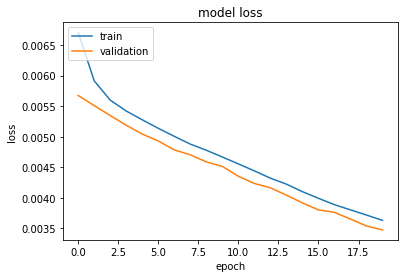

In [155]:
plot_trainingcurves(hist)

### Predicting

In [156]:
#test
predictions = model2.predict(test_inputs, batch_size=10)
truth     = test_targets

predictions = np.reshape(predictions, (len(test_inputs),64,64,3))
truth       = np.reshape(truth, (len(test_targets),64,64,3))

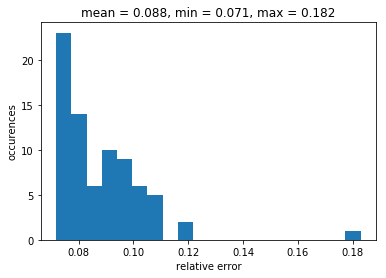

In [157]:
error_distribution(truth,predictions)

In [158]:
args = arg_getter(truth,predictions)

59


### Plot results

59


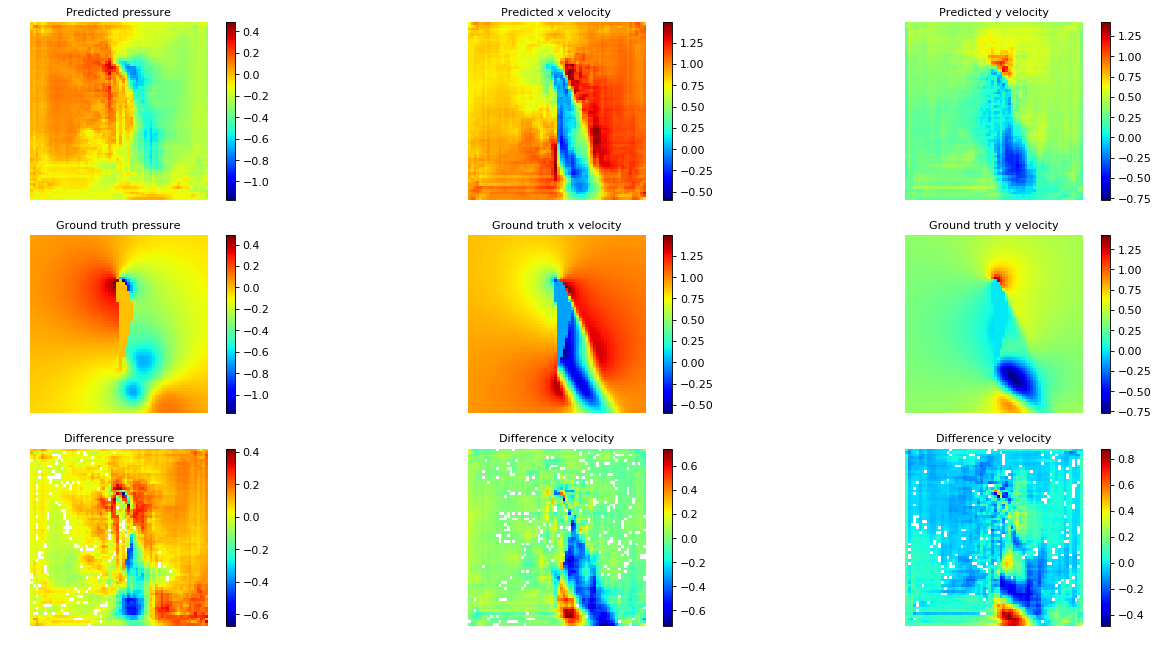

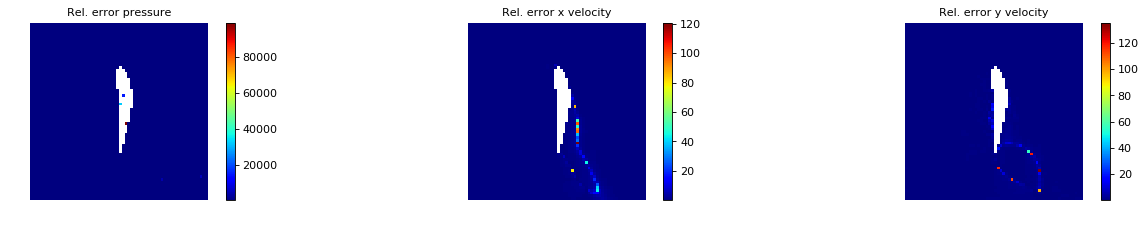

In [161]:
plotter(predictions,truth,index = args[-1])

In [95]:
def get_mean_img(reference,output):
    mean_ref = reference.sum(axis = 0)/len(reference)
    mean_output = output.sum(axis = 0)/len(output)
    rel_err = []
    [rel_err.append(relative_error(mean_ref[:,:,ch], mean_output[:,:,ch])) for ch in range(0,3)]
    return mean_ref, mean_output, rel_err

In [131]:
mean_ref, mean_output, rel_err = get_mean_img(truth[:50],predictions[:50])

In [135]:
np.shape(mean_output)

(64, 64, 3)

In [132]:
rel_err

[0.14014923782662606, 0.027938977350208005, 0.09243308341631926]

In [133]:
np.asarray(rel_err).mean()

0.08684043286438443

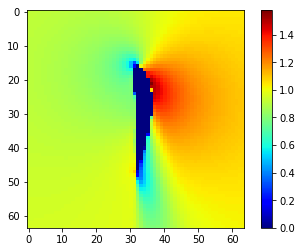

In [134]:
plt.figure()
plt.imshow(mean_ref[:,:,1],cmap = 'jet')
plt.colorbar()

In [186]:
def plotter(predictionset, ground_truth, index=-1):
    """
    Plots various statistics on the training result..
    :param predictionset: predictions
    :param ground_truth: ground truth
    :param index: index 0 is best result, ordered descending
    :return:
    """
    from matplotlib.colors import LogNorm
    
    length = len(predictionset)
    if index > -1:
        sampleindex = index
    else:
        sampleindex = np.random.random_integers(0, length - 1)

    plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    print(sampleindex)
    # predicted data
    plt.subplot(331)
    plt.title('Predicted pressure', fontsize=10)
    plt.imshow(predictionset[sampleindex, :, :, 0], cmap='jet',
               vmin=ground_truth[sampleindex, :, :, 0].min(),
               vmax=ground_truth[sampleindex, :, :, 0].max())
    plt.colorbar()
    plt.axis('off')

    plt.subplot(332)
    plt.title('Predicted x velocity', fontsize=10)
    plt.imshow(predictionset[sampleindex, :, :, 1], cmap='jet',
               vmin=ground_truth[sampleindex, :, :, 1].min(),
               vmax=ground_truth[sampleindex, :, :, 1].max())
    plt.colorbar()
    plt.axis('off')

    plt.subplot(333)
    plt.title('Predicted y velocity', fontsize=10)
    plt.imshow(predictionset[sampleindex, :, :, 2], cmap='jet',
               vmin=ground_truth[sampleindex, :, :, 2].min(),
               vmax=ground_truth[sampleindex, :, :, 2].max())
    plt.colorbar()
    plt.axis('off')

    # ground truth data
    plt.subplot(334)
    plt.title('Ground truth pressure', fontsize=10)
    plt.imshow(ground_truth[sampleindex, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(335)
    plt.title('Ground truth x velocity', fontsize=10)
    plt.imshow(ground_truth[sampleindex, :, :, 1], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(336)
    plt.title('Ground truth y velocity', fontsize=10)
    plt.imshow(ground_truth[sampleindex, :, :, 2], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    # difference
    plt.subplot(337)
    p = ground_truth[sampleindex, :, :, 0] - predictionset[sampleindex, :, :, 0]
    pmask = np.ma.masked_where(np.abs(p) <= 5e-3, p)
    plt.title('Difference pressure', fontsize=10)
    plt.imshow(pmask, cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(338)
    vx = ground_truth[sampleindex, :, :, 1] - predictionset[sampleindex, :, :, 1]
    vxmask = np.ma.masked_where(np.abs(vx) <= 5e-3, vx)
    plt.title('Difference x velocity', fontsize=10)
    plt.imshow(vxmask, cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(339)
    vy = ground_truth[sampleindex, :, :, 2] - predictionset[sampleindex, :, :, 2]
    vymask = np.ma.masked_where(np.abs(vy) <= 5e-3, vy)
    plt.title('Difference y velocity', fontsize=10)
    plt.imshow(vymask, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.show()

    # relative error
    plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    eps = 1e-8
    
    plt.subplot(331)
    plt.title('Rel. error pressure', fontsize=10)
    relerrp = np.abs(ground_truth[sampleindex, :, :, 0]-predictionset[sampleindex, :, :, 0]) /np.abs(ground_truth[sampleindex,:, :, 0] + eps)
    relerrmaskp = np.ma.masked_where(relerrp > 1e5, relerrp)
    plt.imshow(relerrmaskp,cmap='jet',norm=LogNorm(vmin=relerrmaskp.min(), vmax=relerrmaskp.max()))
    plt.colorbar()
    plt.axis('off')

    plt.subplot(332)
    plt.title('Rel. error x velocity', fontsize=10)
    relerrvx = np.abs(ground_truth[sampleindex, :, :, 1]-predictionset[sampleindex, :, :, 1]) /np.abs(ground_truth[sampleindex,:, :,1] + eps)
    relerrmaskvx = np.ma.masked_where(relerrvx > 1e5, relerrvx)
    plt.imshow(relerrmaskvx,cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(333)
    plt.title('Rel. error y velocity', fontsize=10)
    relerrvy = np.abs(ground_truth[sampleindex, :, :, 2] - predictionset[sampleindex, :, :, 2]) /np.abs(ground_truth[sampleindex,:, :, 2] + eps)
    relerrmaskvy = np.ma.masked_where(relerrvy > 1e5, relerrvy)
    plt.imshow(relerrmaskvy,cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.show()
    return relerrvx

59


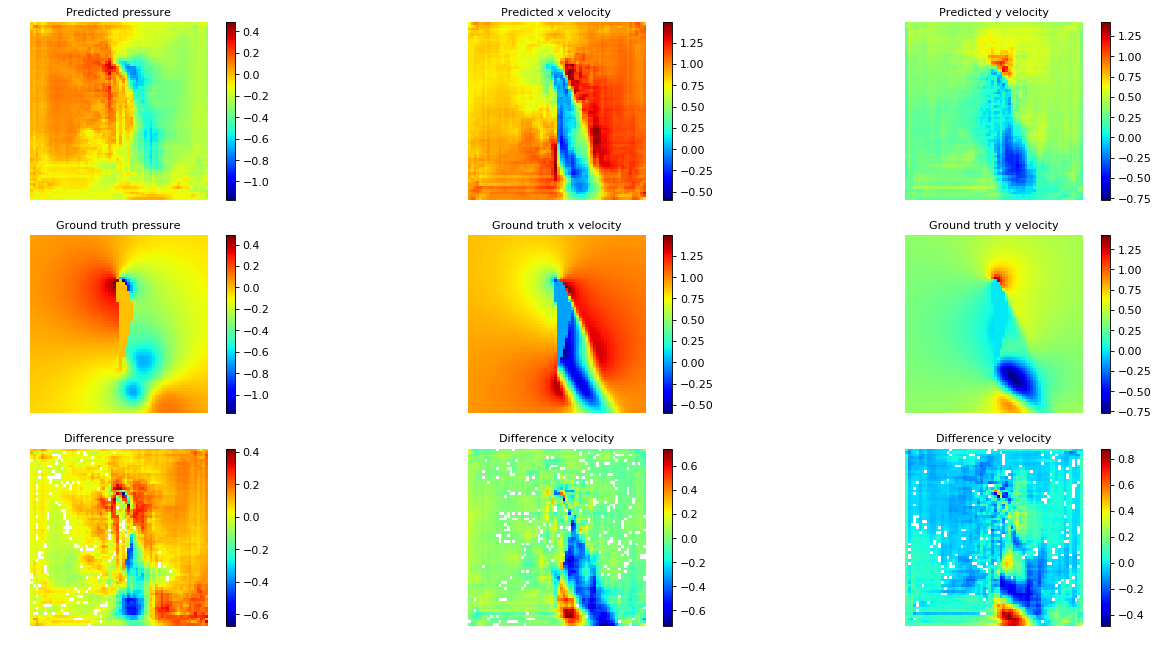

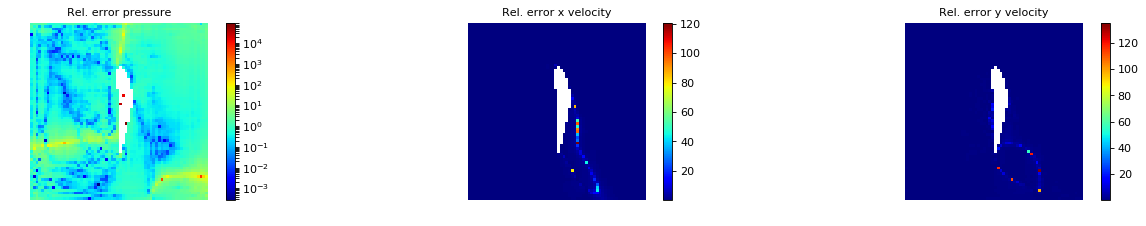

In [187]:
relerrvx = plotter(predictions,truth,index = args[-1])

In [173]:
relerrmaskvx = np.ma.masked_where(relerrvx > 1e5, relerrvx)

In [174]:
relerrmaskvx.max()

19322.335720062256

In [175]:
relerrvx.max()

49632948.63700867

In [176]:
1e5

100000.0